In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

## Loading Dataset

In [2]:
dataset_train = pd.read_csv('PM_train.txt',sep=' ',header=None)
dataset_train.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

In [4]:
dataset_train.drop([26,27],axis=1, inplace=True)
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

In [5]:
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns = col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
dataset_test = pd.read_csv('PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns = col_names
print('Shape of Test dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Test dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [8]:
dataset_train['id']

0          1
1          1
2          1
3          1
4          1
        ... 
20626    100
20627    100
20628    100
20629    100
20630    100
Name: id, Length: 20631, dtype: int64

In [9]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13096 non-null  int64  
 1   cycle     13096 non-null  int64  
 2   setting1  13096 non-null  float64
 3   setting2  13096 non-null  float64
 4   setting3  13096 non-null  float64
 5   s1        13096 non-null  float64
 6   s2        13096 non-null  float64
 7   s3        13096 non-null  float64
 8   s4        13096 non-null  float64
 9   s5        13096 non-null  float64
 10  s6        13096 non-null  float64
 11  s7        13096 non-null  float64
 12  s8        13096 non-null  float64
 13  s9        13096 non-null  float64
 14  s10       13096 non-null  float64
 15  s11       13096 non-null  float64
 16  s12       13096 non-null  float64
 17  s13       13096 non-null  float64
 18  s14       13096 non-null  float64
 19  s15       13096 non-null  float64
 20  s16       13096 non-null  fl

In [10]:
dataset_truth = pd.read_csv('PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
dataset_truth.columns=['more']
dataset_truth['id'] = dataset_truth.index+1
dataset_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [11]:
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [12]:
# run to failure
dataset_truth['rtf'] = dataset_truth['more'] + rul['max']
dataset_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [13]:
dataset_truth.drop('more', axis=1, inplace=True)

dataset_test = dataset_test.merge(dataset_truth,on=['id'], how='left')
dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [14]:
# Time to Failure
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [15]:
df_train = dataset_train.copy()
df_test = dataset_test.copy()
period = 30
df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)

df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [16]:
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [17]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

## Feature Scaling

In [18]:
sc = MinMaxScaler()
df_train[features_col_name] = sc.fit_transform(df_train[features_col_name])
df_test[features_col_name] = sc.transform(df_test[features_col_name])

In [19]:
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


## Function to reshape dataset as required by LSTM

In [20]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [21]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [22]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)

# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 50, seq_cols,'label_bc')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 24)
(20531,)


In [23]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)

# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label_bc')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 24)
(12996,)


## Build Model : LSTM Network

In [26]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50000     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

In [28]:
train_history = model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=200, 
          validation_split=0.05, 
          verbose=1,)

Epoch 1/10
98/98 [==============================] - 19s 170ms/step - loss: 0.3052 - accuracy: 0.8858 - val_loss: 0.0865 - val_accuracy: 0.9601
Epoch 2/10
98/98 [==============================] - 20s 202ms/step - loss: 0.0746 - accuracy: 0.9689 - val_loss: 0.0654 - val_accuracy: 0.9679
Epoch 3/10
98/98 [==============================] - 17s 171ms/step - loss: 0.0732 - accuracy: 0.9703 - val_loss: 0.0507 - val_accuracy: 0.9776
Epoch 4/10
98/98 [==============================] - 18s 181ms/step - loss: 0.0647 - accuracy: 0.9734 - val_loss: 0.0426 - val_accuracy: 0.9805
Epoch 5/10
98/98 [==============================] - 17s 172ms/step - loss: 0.0608 - accuracy: 0.9748 - val_loss: 0.0588 - val_accuracy: 0.9776
Epoch 6/10
98/98 [==============================] - 17s 178ms/step - loss: 0.0590 - accuracy: 0.9745 - val_loss: 0.0546 - val_accuracy: 0.9766
Epoch 7/10
98/98 [==============================] - 17s 170ms/step - loss: 0.0621 - accuracy: 0.9732 - val_loss: 0.0686 - val_accuracy: 0.9669

In [29]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))


204/204 [==============================] - 5s 21ms/step
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     12664
         1.0       0.00      0.00      0.00       332

    accuracy                           0.97     12996
   macro avg       0.49      0.50      0.49     12996
weighted avg       0.95      0.97      0.96     12996



/Users/kainie56560005/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
y_pred = model.predict_classes(X_test)
print(y_pred)
print()
print('Accuracy of model on test data: ', accuracy_score(y_test, y_pred))
print()
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))


/Users/kainie56560005/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]

Accuracy of model on test data:  0.9903047091412742

Confusion Matrix: 
 [[12648    16]
 [  110   222]]


In [31]:
score = model.evaluate(x=X_train, y=y_train)
print('\nTrain loss:', score[0])
print('\nTrain acc:', score[1])

642/642 [==============================] - 9s 14ms/step - loss: 0.0566 - accuracy: 0.9768

Train loss: 0.05662960186600685

Train acc: 0.97676682472229


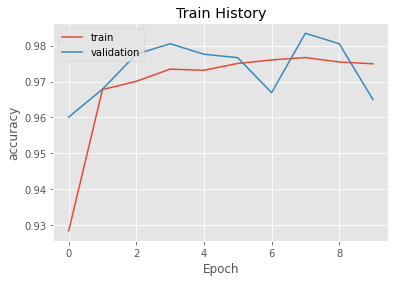

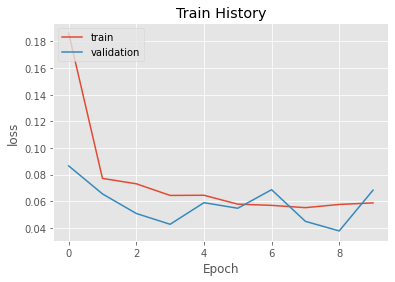

In [32]:
#建置繪圖函式
def show_train_history(train_history,train,validation,label):
    #請輸入程式碼
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(label)
    plt.xlabel('Epoch')
    
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

#訓練結果
show_train_history(train_history, 'accuracy', 'val_accuracy', 'accuracy')
show_train_history(train_history, 'loss', 'val_loss', 'loss')



## Probability of Machine failure

In [33]:
def prob_failure(machine_id):
    machine_df = df_test[df_test.id == machine_id]
    machine_test = gen_sequence(machine_df, seq_length, seq_cols)
    m_pred = model.predict(machine_test)
    failure_prob = list(m_pred[-1]*100)[0]
    return failure_prob

In [34]:
machine_id = 16
print('Probability that machine will fail within 30 days: ',prob_failure(machine_id))

Probability that machine will fail within 30 days:  0.008422201
